# Project 3 - DTW, HMM, GMM based isolated word recognition

----
Authors: Junkai Man, Tzu-Liang Huang

Time: Feb 9, 2022

Slides: https://docs.google.com/presentation/d/1_xLHDoQfqJJunJVtGcbc3xwNR0qVA1MzkcqNn8X7-BU/edit?usp=sharing


## Outline

0. Changes since project-2
1. DTW
    1. Single template DTW
    2. Multiple templates DTW (time-sync)
    3. Do the above with pruning
    4. Plots, Accuracy test
2. HMM-based for Single Gaussian
3. HMM-based for Gaussian Mixture (n=4)

-------


## 0. Changes since project-2

Mainly three changes:
1. Improve the APIs
2. Mean, var normalize, Calculate delta and get 39 dimension mfcc
3. Read from .wav file and segment it to frames

In [5]:
from itertools import chain, repeat, islice
import pyaudio
import wave
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
from scipy.fftpack import ifft, idct

class Frame:
    '''
    The Frame class has the following properties:
    1. decoded: the decoded values (int64) of each frame
    2. processed: the values after pre-emphasis and hamming windowing
    3. energy: the log energy of each frame 
    4. speech: whether the frame is classified as speech or not
    5. speech_smoothed: whether the frame is classfied as speech or not after labele smoothing
    6. mfcc: mfcc vector
    7. mfcc_idct: idct spectra
    8. filter_banks: original spectrogram
    '''
    def __init__(self, decoded):
        decoded = np.array(decoded)
        self.decoded = decoded
        self.processed = self.process(decoded)
        self.energy = self._calc_energy()
        self.speech = 0
        self.speech_smoothed = 0
        self.mfcc = None
        self.mfcc_idct = None
        self.filter_banks = None

    def _calc_energy(self):
        sum = 0.
        for val in self.decoded: sum += float(val) ** 2
        energy = 0 if sum < 1 else (10 * np.log10(sum))
        return energy
    def process(self, decoded):
        pre_emphasis = 0.97
        processed = np.append(decoded[0], decoded[1:] - pre_emphasis * decoded[:-1])
        processed *= np.hamming(len(decoded))
        return processed

class Recorder:
    def __init__(
        self,
        channels=1,
        rate=16000, 
        frames_per_buffer=3200, 
        filename="recorded.wav",
        endPo_settings={
        }):
        self.channels = channels
        self.rate = rate
        self.frames_per_buffer = frames_per_buffer
        self.frameSize = 320
        self.filename = filename
        self._pa = pyaudio.PyAudio()
        self._raw_audio = []
        self._frames = []
        self.endPo_settings = endPo_settings
        self.isRecording = False
        self._current_frame = 0
        self.accumulated_silence_frames = 0
        self.level = None
        self.background = None
        self.startFrame = int(self.endPo_settings['startTime'] * self.rate / self.frameSize * 2)
        self.stopFrame = int(self.endPo_settings['stopTime'] * self.rate / self.frameSize * 2)
        self.nfilt = int(self.endPo_settings['nfilt'])

    def get_energy_list(self):
        return np.array([frame.energy for frame in self._frames[self.startFrame+1:]])

    def get_speech_list(self):
        return np.array([frame.speech for frame in self._frames[self.startFrame+1:]])

    def get_speech_smoothed_list(self):
        return np.array([frame.speech_smoothed for frame in self._frames[self.startFrame+1:]])

    def get_filter_banks_list(self):
        return np.array([frame.filter_banks for frame in self._frames[self.startFrame+1:]])

    def get_mfcc_list(self):
        return np.array([frame.mfcc for frame in self._frames[self.startFrame+1:]])

    def get_idct_mfcc_list(self):
        return np.array([frame.mfcc_idct for frame in self._frames[self.startFrame+1:]])


    def _get_callback(self):
        def default_callback(in_data, frame_count, time_info, status):
            if self.isRecording:
                '''
                Save the original raw_audio data to the list.
                '''
                self._raw_audio.append(in_data)
                decoded = np.frombuffer(in_data, dtype=np.int16)
                FRAME_SIZE = self.frameSize
                cur_sample = 0
                '''
                Frame the decoded data to multiple frames, and append each frame to the _frames list.
                '''
                if len(self._frames) != 0:
                    tmp = []
                    tmp.extend(self._frames[-1].decoded[-FRAME_SIZE // 2:])
                    tmp.extend(decoded[:FRAME_SIZE // 2])
                    self._frames.append(Frame(tmp))
                while cur_sample < frame_count - FRAME_SIZE // 2:
                    self._frames.append(Frame(decoded[cur_sample: cur_sample + FRAME_SIZE]))
                    cur_sample += FRAME_SIZE // 2
                return (None, pyaudio.paContinue)
            else:
                return (None, pyaudio.paComplete)
        return default_callback

    def classify_speech(self, frame: Frame, mode: str, last_speech_status: int = 0):
        if mode == 'adaptive':
            forgetFactor = self.endPo_settings["forgetFactor"]
            adjustment = self.endPo_settings["adjustment"]
            threshold = self.endPo_settings["threshold"]
            
            current = frame.energy
            isSpeech = 0
            self.level = ((self.level * forgetFactor) + current) / (forgetFactor + 1)
            if (current < self.background):
                self.background = current
            else:
                self.background += (current - self.background) * adjustment
            if (self.level < self.background):
                self.level = self.background
            if (self.level - self.background) > threshold:
                isSpeech = 1
            frame.speech = isSpeech
            frame.speech_smoothed = isSpeech
            return isSpeech
        elif mode == 'onset':
            dynamicRange = self.endPo_settings["dynamicRange"]
            alpha = self.endPo_settings["alpha"]
            trackingFactor = self.endPo_settings["trackingFactor"]
            
            energy = frame.energy
            onsetThreshold = self.endPo_settings['onsetThreshold']
            offsetThreshold = onsetThreshold - dynamicRange
            isSpeech = last_speech_status
            if bool(isSpeech) and (energy - self.background) < offsetThreshold:
                isSpeech = 0
            elif (energy - self.background) > onsetThreshold:
                isSpeech = 1  
            if bool(isSpeech):
                self.background += (energy - self.background) * trackingFactor
            else:
                self.background = alpha * self.background + (1 - alpha) * energy
            frame.speech = isSpeech
            frame.speech_smoothed = isSpeech
            return isSpeech

    def calculate_mfcc(self, frame: Frame):
        nfilt = self.endPo_settings["nfilt"]
        
        '''
        Fast Fourier-Transform
        It is difficult to see the changing of the signal on time domain, so we use FFT to coverted into frequency domian to capture the changing.
        Different energy distributino on frequency domain represet different characteristics of different speech.
        '''

        # set N to 512
        NFFT = 512
        m_frames = np.absolute(np.fft.rfft(frame.processed, NFFT))
        
        # Power Spectrum
        p_frames = ((1.0 / NFFT) * (m_frames ** 2))
        
        '''
        Mel frequency mimic the sensitivity of the human ear to frequency, 
        from which it can also be seen that the perception of the human ear to frequency F is logarithmic.
        '''
         # Convert Hz to Mel, within 0Hz and sample_rate/2 (8000Hz)
        low_mel = 0
        high_mel = (2595 * np.log10(1 + (self.rate / 2) / 700)) 
        
        # The Mel scale is equally spaced
        mel_points = np.linspace(low_mel, high_mel, nfilt + 2)  
        
        # Convert Mel to Hz
        hz_points = (700 * (10**(mel_points / 2595) - 1)) 
        bin = np.floor((NFFT + 1) * hz_points / self.rate)
        
        '''
        filter banks is applying triangular filters on a Mel-scale to the power spectrum to extract frequency bands.
        '''
        
        # Values of each mel filter at corresponding points of the spectrum
        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            mel_small = int(bin[m - 1])  
            mel_center = int(bin[m])           
            mel_big = int(bin[m + 1])   

            for k in range(mel_small, mel_center):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(mel_center, mel_big):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
        filter_banks = np.dot(p_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        
        # dB energy
        filter_banks = 10 * np.log10(filter_banks)  
        '''
        The discrete cosine transform (DCT) is applied to remove the filter bank coefficients 
        and generate a compressed filter bank representation.
        The cepstrum coefficients 13 were retained and the rest were discarded
        '''

        #remained cepstrum coefficients
        num_ceps = 13
        single_mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=0, norm='ortho')
        single_mfcc = single_mfcc[1 : (num_ceps + 1)]
        
        '''
        Since the higher cepstral coefficients proveds less discrimination for speech recognition 
        than the lower cepstral coefficients. The  sinusoidal lifter give less weight to higher cepstral 
        coefficients and hence, proved better recognition performance for clean speech.
        
        In brief, the high-frequency part will be de-emphasized and the noise will be weakened
        '''
        cep_lifter = 22
        ncoeff = single_mfcc.shape[0]
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        single_mfcc *= lift

        # zero padding
        def pad_infinite(iterable, padding=None):
            return chain(iterable, repeat(padding))
        
        def pad(iterable, size, padding=None):
            return islice(pad_infinite(iterable, padding), size)        
        single_mfcc_idct = list(pad(single_mfcc, 64, 0))
        
        # inverse dct of mfcc
        single_mfcc_idct = idct(single_mfcc_idct, norm='ortho')

        frame.mfcc = single_mfcc
        frame.filter_banks = filter_banks
        frame.mfcc_idct = single_mfcc_idct
    
    #################################
    ##
    ##  Here is what we updated
    ##
    #################################
    def get_full_mfcc_list(self):
        def delta(feat, N=2):
            """Compute delta features from a feature vector sequence.
            :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
            :param N: For each frame, calculate delta features based on preceding and following N frames
            :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
            """
            if N < 1:
                raise ValueError('N must be an integer >= 1')
            NUMFRAMES = len(feat)
            denominator = 2 * sum([i**2 for i in range(1, N+1)])
            delta_feat = np.empty_like(feat)
            padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
            for t in range(NUMFRAMES):
                delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
            return delta_feat
        
        #mfcc
        feat = self.get_mfcc_list()
        #delta mfcc
        delta_feat = delta(feat, 2)
        #delta_delta_mfcc
        delta_delta_feat = delta(delta_feat, 2)
        
        def normalize(mfcc):
            #mean normalize
            mean = np.sum(mfcc, axis = 0)/len(mfcc)
            normalized_mfcc = mfcc - mean
            #variance normalize
            var = np.sqrt(np.sum(np.power(normalized_mfcc, 2), axis = 0))/ len(mfcc)
            variance_normalixed_mfcc = normalized_mfcc/var
            return variance_normalixed_mfcc     
        
        #normalized mfcc
        feat = normalize(feat)
        delta_feat = normalize(delta_feat)
        delta_delta_feat = normalize(delta_delta_feat)
        
        final_mfcc = np.hstack([feat, delta_feat, delta_delta_feat])
        
        return final_mfcc

    #################################
    ##                             ##
    ##  Here is what we updated    ##
    ##                             ## 
    #################################
    def read_file(self, filename):
        self._frames = []
        # append frames to self._frames
        file = wave.open(filename, 'rb')
        self.rate = file.getframerate()
        self.channels = file.getnchannels()
        raw_buffer = file.readframes(file.getnframes())
        decoded = np.frombuffer(raw_buffer, dtype=np.int16)
        cur_sample = 0
        FRAME_SIZE = self.frameSize
        while cur_sample < len(decoded) - FRAME_SIZE // 2: 
            frame = Frame(decoded[cur_sample: cur_sample + FRAME_SIZE])
            self._frames.append(frame)
            cur_sample += FRAME_SIZE // 2

        # append other properties to self
        self.startFrame = int(self.endPo_settings['startTime'] * self.rate / self.frameSize * 2)
        self._frames_data = np.array([frame.processed for frame in self._frames[self.startFrame+1:]]).flatten()
        self._timeLength = len(self._frames_data) / float(self.rate) / 2

        # calculate mfcc
        for frame in self._frames:
            self.calculate_mfcc(frame)

    def start(self):
        """
        Start recording.
        """
        input("Start recording? (Enter)")
        self.isRecording = True
        self._stream = self._pa.open(
            format=pyaudio.paInt16,
            channels=self.channels,
            rate=self.rate,
            input=True,
            frames_per_buffer=self.frames_per_buffer,
            stream_callback=self._get_callback(),
        )
        while self._stream.is_active():
            timeLength = len(self._raw_audio) * self.frames_per_buffer / self.rate
            if self._current_frame < len(self._frames): # If there are frames left
                if self._current_frame > self.startFrame: # If grater than the start frame we've set
                    if (self.level is None) or (self.background is None): # Set background and level
                        self.level = self._frames[self._current_frame].energy
                        self.background = np.average([frame.energy for frame in self._frames[self.startFrame+1:]])

                    ## Classify the speech label, and smooth it
                    last_speech_status = self._frames[self._current_frame - 1].speech_smoothed
                    pauseFrames = int(self.endPo_settings['pauseTime'] * self.rate / self.frameSize * 2)
                    last_few_speech_status = [x.speech_smoothed for x in self._frames[self._current_frame - pauseFrames: self._current_frame]]
                    isSpeech = self.classify_speech(self._frames[self._current_frame], self.endPo_settings['mode'], last_speech_status)

                    if (last_speech_status == 0) and (isSpeech == 0):
                        self.accumulated_silence_frames += 1
                    else:
                        self.accumulated_silence_frames = 0
                    if (last_speech_status == 0) and np.sum(last_few_speech_status) > 0:
                        for frame in self._frames[self._current_frame - pauseFrames: self._current_frame]:
                            frame.speech_smoothed = 1

                    # Calculate the MFCC
                    self.calculate_mfcc(self._frames[self._current_frame])

                # If greater than the end frame we expect, determine whether the speech is complete and stop recording
                if self._current_frame > self.stopFrame:
                    if self.accumulated_silence_frames > int(self.endPo_settings['silenceTime'] * self.rate / self.frameSize * 2):
                        self.isRecording = False

                self._current_frame += 1
        # print("[INFO] Stop recording")
        self.save()
        # self.plot()
        # self.plot_spec()
        # self.plot_ceps()
        # self.plot_idct_ceps()
        return self
    
    def save(self):
        '''
        Save frames to the file.
        '''
        self._frames_data = np.array([frame.processed for frame in self._frames[self.startFrame+1:]]).flatten()
        self._timeLength = len(self._frames_data) / float(self.rate) / 2
        wf = wave.open(self.filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.rate)
        wf.writeframes(b''.join(self._raw_audio))
        wf.close()
        return self

    def terminate(self):
        '''
        Manually terminate the Recorder. Close and terminate all related process.
        '''
        self._stream.close()
        self._pa.terminate()
        print("[INFO] Recorder terminated")
        return self

    def plot_spec(self):
        """
        Plot the spectrogram.
        """
        khz = self.rate / 2000
        plt.figure(figsize=(20, 5))
        filter_banks_list = self.get_filter_banks_list()
        plt.imshow(filter_banks_list.T, cmap=plt.cm.jet, origin='lower', aspect='auto', extent=[0, self._timeLength, 0, khz])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('spectrogram')
        plt.tight_layout()
        plt.show()

    def plot_idct_ceps(self):
        """
        Plot the idct derived spectrogram.
        """
        khz = self.rate/2000
        plt.figure(figsize=(20, 5))
        idct_mfcc_list = self.get_idct_mfcc_list()
        plt.imshow(idct_mfcc_list.T, cmap=plt.cm.jet, origin='lower', aspect='auto',extent=[0, self._timeLength, 0, khz])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('IDCT-derived logspectrum')
        plt.tight_layout()
        plt.show()
    
    def plot_ceps(self):
        """
        Plot the mfcc coefficients cepstrum.
        """
        plt.figure(figsize=(20, 5))
        mfcc_list = self.get_mfcc_list()
        plt.imshow(mfcc_list.T, cmap=plt.cm.jet, origin='lower', aspect='auto',extent=[0, self._timeLength, 0, 13])
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC')
        plt.title('MFCC Coefficients cepstrum')
        plt.tight_layout()
        plt.show()
        

    def plot(self):
        '''
        Plot the sound graph with raw_speechStatus in blue and smoothed_speechStatus in red.
        '''
        data = self._frames_data
        duration = 1 / float(self.rate)
        t = np.arange(0, self._timeLength, duration / 2)
        fig, ax = plt.subplots(figsize=(30, 10))
        ax.plot(t, data)
        ax2 = ax.twinx()
        raw_speechStatus = self.get_speech_list()
        raw_speechStatus = np.repeat(raw_speechStatus, self.frameSize)
        smoothed_speechStatus = self.get_speech_smoothed_list()
        smoothed_speechStatus = np.repeat(smoothed_speechStatus, self.frameSize)
        ax2.plot(t, raw_speechStatus, 'b')
        ax2.plot(t, smoothed_speechStatus, 'r')
        fig.show()
        fig.savefig('wave.png')
        print("[INFO] Plot and Wave saved")
        return self

In [6]:
settings = {
    "mode": "onset",
    "startTime": 0.2,
    "stopTime": 1,
    "silenceTime": 0.25,
    "pauseTime": 0.1,
    "nfilt": 40,
    "alpha": 0.4,
    "trackingFactor": 0.01,
    "onsetThreshold": 5,
    "dynamicRange": 3,
}

"""
    Create a rec2 to read file and get_full_mfcc_list()
"""
rec2 = Recorder(
    endPo_settings=settings
)

## 1. DTW based

### 1.1 Single template DTW

In [205]:
from scipy.spatial.distance import cdist
def dtw(query, template, pruning=False, pruning_T=1000, dist='euclidean'):
    M = template.shape[0]
    N = query.shape[0]
    dist_mat = cdist(template, query, dist)
    cost_mat = np.zeros((M+2, N+1)) + np.inf
    cost_mat[0, 0] = 0
    traceback_mat = np.zeros((M, N))
    for j in range(N):
        for i in range(M):
            penalty = [
                cost_mat[i+2, j],      # horizon (0)
                cost_mat[i+1, j],      # diag (1)
                cost_mat[i, j]         # super-diag (2) 
            ]
            i_penalty = np.argmin(penalty)
            cost_mat[i+2, j+1] = penalty[i_penalty] + dist_mat[i, j]
            traceback_mat[i, j] = i_penalty
        if pruning:
            optimized_cost = np.min(cost_mat[2:, j+1])
            for i in range(M):
                if cost_mat[i+2, j+1] > optimized_cost + pruning_T:
                    cost_mat[i+2, j+1] = np.inf

    cost_mat = cost_mat[2:, 1:]

    i = M - 1 - np.argmax(cost_mat[:, -1][::-1] < np.inf)
    j = N - 1
    last_index = (i, j)
    path = [last_index]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        # print(tb_type)
        if tb_type == 0:
            # horizon
            j = j - 1
        elif tb_type == 1:
            # diag
            i = i - 1
            j = j - 1
        elif tb_type == 2:
            # super-diag
            i = i - 2
            j = j - 1
        path.append((i, j))
    result = cost_mat[path[0]] / (M+N)
    return (path[::-1], dist_mat, cost_mat, result)


In [209]:
"""
    Initialize the templates and queries
"""
number = "three_1"
rec2.read_file("templates/{}.wav".format(number))
template = rec2.get_full_mfcc_list()
template_spectrogram = rec2.get_filter_banks_list().T

rec2.read_file("queries/{}.wav".format(number))
query = rec2.get_full_mfcc_list()
query_spectrogram = rec2.get_filter_banks_list().T

Alignment cost: 6194.8355
Normalized alignment cost: 28.67979376924861


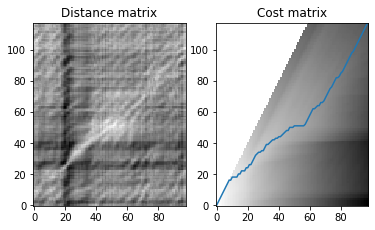

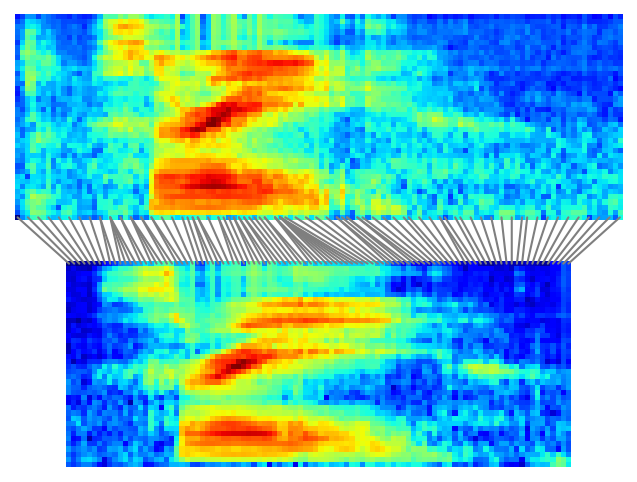

In [210]:
path, dist_mat, cost_mat, result = dtw(query, template, pruning_T=300, pruning=False)
M = template.shape[0]
N = query.shape[0]


print("Alignment cost: {:.4f}".format(cost_mat[path[-1]]))
# print("Normalized alignment cost: {:.4f}".format(cost_mat[path[-1]]/(M + N)))
print("Normalized alignment cost: {}".format(result))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Distance matrix")
ax1.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")

ax2.set_title("Cost matrix")
ax2.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
ax2.plot(y_path, x_path)

from matplotlib.patches import ConnectionPatch
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150)

ax1.imshow(template_spectrogram, origin="lower", interpolation="nearest", cmap='jet', aspect='1')
ax2.imshow(query_spectrogram, origin="lower", interpolation="nearest", cmap='jet', aspect='1')
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, query_spectrogram.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

### 1.2 Stacked-templates DTW (Time-sync)

In [7]:
from scipy.spatial.distance import cdist
# import time
def multi_templates_dtw(query, templates, pruning=False, pruning_T=1000, dist='euclidean'):
    inf_row = np.zeros(query.shape[0]) + np.inf
    dist_mat = inf_row.copy()
    corner_indexes = []
    remaining_templates = [i for i in range(len(templates))]
    for template in templates:
        dist_mat = np.vstack((dist_mat, inf_row, inf_row))
        tmp_mat = cdist(template, query, dist)
        dist_mat = np.vstack((dist_mat, tmp_mat))
        corner = [(dist_mat.shape[0] - tmp_mat.shape[0] - 1, 1), (dist_mat.shape[0] - 2, dist_mat.shape[1])]
        corner_indexes.append(corner) 
    dist_mat = dist_mat[1:, :]
    inf_col = np.zeros((dist_mat.shape[0], 1)) + np.inf
    dist_mat = np.hstack((inf_col, dist_mat))
    M, N = dist_mat.shape
    cost_mat = np.zeros((M, N)) + np.inf
    active_mat = np.zeros((M, N))
    for corner in corner_indexes:
        cost_mat[corner[0][0] - 2, corner[0][1] - 1] = 0
    traceback_mat = np.zeros((M, N))
    for j in range(1, N):
        for i in range(2, M):
            if pruning and active_mat[i, j] == 1:
                continue
            penalty = [
                np.inf,                 # stop (0)
                cost_mat[i, j-1],       # horizon (1)
                cost_mat[i-1, j-1],     # diag (2)
                cost_mat[i-2, j-1]]      # super-diag (3) 
            i_penalty = np.argmin(penalty)
            traceback_mat[i, j] = i_penalty
            cost_mat[i, j] = penalty[i_penalty] + dist_mat[i, j]
        if pruning:
            for i in remaining_templates:
                corner = corner_indexes[i]
                if np.min(cost_mat[corner[0][0]:corner[1][0], j]) == np.inf:
                    active_mat[corner[0][0]:corner[1][0], :] = 1
                    remaining_templates.remove(i)
            optimized_cost = np.min(cost_mat[:, j])
            for i in range(M):
                if cost_mat[i, j] > optimized_cost + pruning_T:
                    cost_mat[i, j] = np.inf

    paths = []
    for i in range(len(corner_indexes)):
        corner = corner_indexes[i]
        template_length = templates[i].shape[0]
        # starting from the most upper right cell
        i, j = corner[1]
        k, l = corner[0]
        last_index = (i, j)
        path = [last_index]
        while i > k or j > l:
            # print("i: {}, j: {}".format(i, j))
            tb_type = traceback_mat[i, j]
            if tb_type == 0:
                break
            elif tb_type == 1: # horizon
                j = j - 1   
            elif tb_type == 2: # diag
                i = i - 1
                j = j - 1
            elif tb_type == 3: # super-diag
                i = i - 2
                j = j - 1
            path.append((i, j))
        paths.append(path[::-1])
        # print("=======================")
    """
    Return the result scores
    """
    results = []
    for i in range(len(corner_indexes)):
        corner_i = corner_indexes[i]
        results.append(cost_mat[corner_i[1]] / (templates[i].shape[0] + query.shape[0])) # normalized cost
    return (paths, dist_mat, cost_mat, corner_indexes, results)


In [213]:
"""
    Prepare the query and templates
"""
num_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# num_list = ['zero', 'one', 'two', 'three', 'four']
templates = []
for num in num_list:
    rec2.read_file("templates/{}_1.wav".format(num))
    template = rec2.get_full_mfcc_list()
    templates.append(template)

num = "two"
rec2.read_file("queries/{}_1.wav".format(num))
query = rec2.get_full_mfcc_list()

[41.77288948708847, 45.856719580252935, 38.43203707684805, 40.70593951754555, 44.51071666878166, 43.348520759956365, 45.01747959623787, 41.95799881766943, 43.08242670385766, 44.81763641395173]


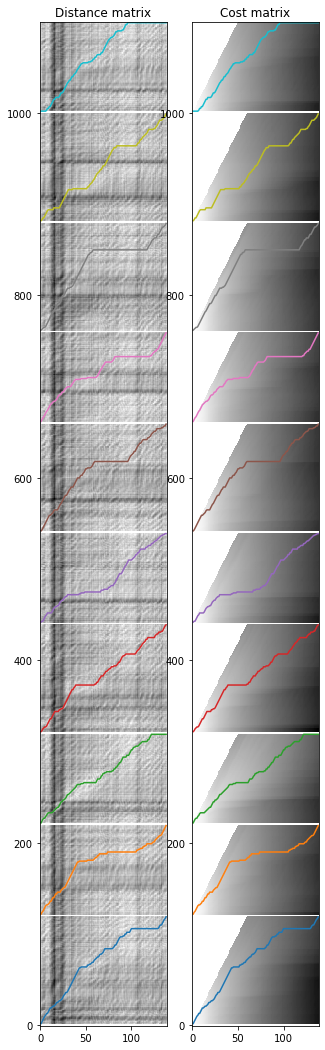

In [214]:
"""
    Visualize the results
"""
paths, dist_mat, cost_mat, corner_indexes, results = multi_templates_dtw(query, templates, pruning=False, pruning_T=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 20))
ax1.set_title("Distance matrix")
ax1.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")

ax2.set_title("Cost matrix")
ax2.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
for path in paths:
    x_path, y_path = zip(*path)
    ax1.plot(y_path, x_path)
    ax2.plot(y_path, x_path)
print(results)

### 1.3 Do the above with Pruning

Alignment cost: 6133.8811
Normalized alignment cost: 28.39759784165107


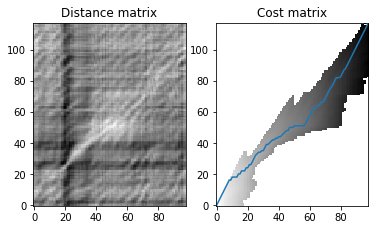

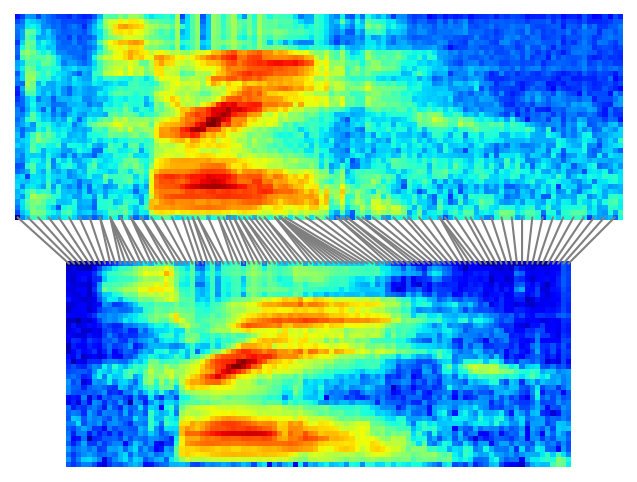

In [216]:
"""
    Initialize the templates and queries
"""
number = "three_1"
rec2.read_file("templates/{}.wav".format(number))
template = rec2.get_full_mfcc_list()
template_spectrogram = rec2.get_filter_banks_list().T

rec2.read_file("queries/{}.wav".format(number))
query = rec2.get_full_mfcc_list()
query_spectrogram = rec2.get_filter_banks_list().T



path, dist_mat, cost_mat, result = dtw(query, template, pruning_T=300, pruning=True)
M = template.shape[0]
N = query.shape[0]
print("Alignment cost: {:.4f}".format(cost_mat[path[-1]]))
# print("Normalized alignment cost: {:.4f}".format(cost_mat[path[-1]]/(M + N)))
print("Normalized alignment cost: {}".format(result))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Distance matrix")
ax1.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")

ax2.set_title("Cost matrix")
ax2.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
ax2.plot(y_path, x_path)

from matplotlib.patches import ConnectionPatch
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150)

ax1.imshow(template_spectrogram, origin="lower", interpolation="nearest", cmap='jet', aspect='1')
ax2.imshow(query_spectrogram, origin="lower", interpolation="nearest", cmap='jet', aspect='1')
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, query_spectrogram.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

[inf, inf, 38.43203707684805, inf, inf, inf, inf, inf, inf, inf]


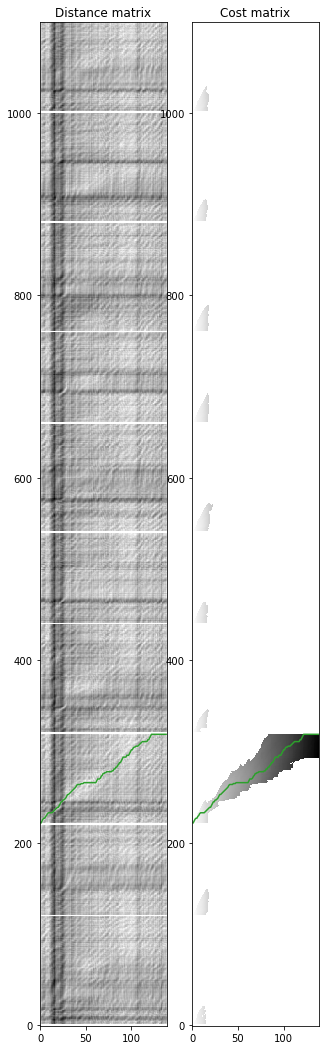

In [217]:
"""
    Prepare the query and templates
"""
num_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# num_list = ['zero', 'one', 'two', 'three', 'four']
templates = []
for num in num_list:
    rec2.read_file("templates/{}_1.wav".format(num))
    template = rec2.get_full_mfcc_list()
    templates.append(template)

num = "two"
rec2.read_file("queries/{}_1.wav".format(num))
query = rec2.get_full_mfcc_list()

"""
    Visualize the results
"""
paths, dist_mat, cost_mat, corner_indexes, results = multi_templates_dtw(query, templates, pruning=True, pruning_T=300)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 20))
ax1.set_title("Distance matrix")
ax1.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")

ax2.set_title("Cost matrix")
ax2.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
for path in paths:
    x_path, y_path = zip(*path)
    ax1.plot(y_path, x_path)
    ax2.plot(y_path, x_path)
print(results)

### 1.4 Plots, Accuracy test

#### Single template DTW

In [218]:
import time
nums = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
indexes = [1, 2, 3, 4, 5]

# read templates and queries
templates = []
for num in nums:
    rec2.read_file("templates/{}_1.wav".format(num))
    template = rec2.get_full_mfcc_list()
    templates.append(template)
queries = {}
for num in nums:
    queries[num] = []
    for index in indexes:
        rec2.read_file("queries/{}_{}.wav".format(num, index))
        query = rec2.get_full_mfcc_list()
        queries[num].append(query)

starTime = time.time()
count = 0
correct_count = 0
for num_index, query_num in enumerate(nums):
    for index in indexes:
        results = []
        count += 1
        query = queries[query_num][index-1]
        for template_index, template in enumerate(templates):
            print("query: {}, template: {}".format(query_num + "_" + str(index), nums[template_index] + "_1"))
            _, _, _, result = dtw(query, template, pruning=False)
            results.append(result)
        if np.argmin(results) == num_index:
            print("correct")
            correct_count += 1

print("==========")
print("Accuracy rate: ", correct_count / count)
endTime = time.time()
print("Running time: ", endTime - starTime)

query: zero_1, template: zero_1
query: zero_1, template: one_1
query: zero_1, template: two_1
query: zero_1, template: three_1
query: zero_1, template: four_1
query: zero_1, template: five_1
query: zero_1, template: six_1
query: zero_1, template: seven_1
query: zero_1, template: eight_1
query: zero_1, template: nine_1
correct
query: zero_2, template: zero_1
query: zero_2, template: one_1
query: zero_2, template: two_1
query: zero_2, template: three_1
query: zero_2, template: four_1
query: zero_2, template: five_1
query: zero_2, template: six_1
query: zero_2, template: seven_1
query: zero_2, template: eight_1
query: zero_2, template: nine_1
correct
query: zero_3, template: zero_1
query: zero_3, template: one_1
query: zero_3, template: two_1
query: zero_3, template: three_1
query: zero_3, template: four_1
query: zero_3, template: five_1
query: zero_3, template: six_1
query: zero_3, template: seven_1
query: zero_3, template: eight_1
query: zero_3, template: nine_1
correct
query: zero_4, t

#### Single template DTW with pruning

====pruning_T: 1====
query=zero_1: incorrect
query=zero_2: incorrect
query=zero_3: incorrect
query=zero_4: incorrect
query=zero_5: incorrect
query=one_1: incorrect
query=one_2: incorrect
query=one_3: correct
query=one_4: incorrect
query=one_5: incorrect
query=two_1: incorrect
query=two_2: correct
query=two_3: incorrect
query=two_4: correct
query=two_5: incorrect
query=three_1: incorrect
query=three_2: correct
query=three_3: incorrect
query=three_4: incorrect
query=three_5: correct
query=four_1: correct
query=four_2: incorrect
query=four_3: incorrect
query=four_4: incorrect
query=four_5: incorrect
query=five_1: correct
query=five_2: correct
query=five_3: incorrect
query=five_4: incorrect
query=five_5: correct
query=six_1: correct
query=six_2: incorrect
query=six_3: correct
query=six_4: correct
query=six_5: incorrect
query=seven_1: incorrect
query=seven_2: correct
query=seven_3: correct
query=seven_4: incorrect
query=seven_5: correct
query=eight_1: incorrect
query=eight_2: correct
query=

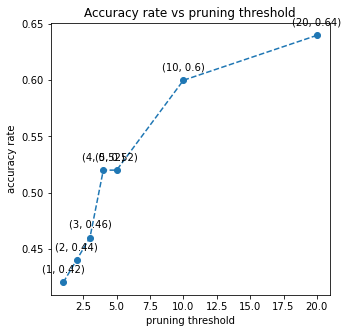

In [219]:
pruning_Ts = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400]
acc_list = []
for pruning_T in pruning_Ts:
    print("====pruning_T: {}====".format(pruning_T))
    starTime = time.time()
    count = 0
    correct_count = 0
    for num_index, query_num in enumerate(nums):
        for index in indexes:
            results = []
            count += 1
            query = queries[query_num][index-1]
            for template_index, template in enumerate(templates):
                # print("query: {}, template: {}".format(query_num + "_" + str(index), nums[template_index] + "_1"))
                _, _, _, result = dtw(query, template, pruning_T=pruning_T, pruning=True)
                results.append(result)
            if np.argmin(results) == num_index and np.min(results) != np.inf:
                print("query={}_{}: correct".format(query_num, index))
                correct_count += 1
            else:
                print("query={}_{}: incorrect".format(query_num, index))

    print("==========")
    acc = correct_count / count
    print("Accuracy rate: ", acc)
    acc_list.append(acc)
    endTime = time.time()
    print("Running time: ", endTime - starTime)

plt.figure(figsize=(5,5))
plt.plot(pruning_Ts[:-7], acc_list[:-7], '--o')
plt.title("Accuracy rate vs pruning threshold")
plt.xlabel("pruning threshold")
plt.ylabel("accuracy rate")
for x,y in zip(pruning_Ts, acc_list):
    label = f"({x}, {y})"
    plt.annotate(label,
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

#### Stacked-templates DTW 

=====pruning_T=1=====
query=zero_1: incorrect
query=zero_2: incorrect
query=zero_3: incorrect
query=zero_4: incorrect
query=zero_5: incorrect
query=one_1: incorrect
query=one_2: incorrect
query=one_3: incorrect
query=one_4: incorrect
query=one_5: incorrect
query=two_1: incorrect
query=two_2: incorrect
query=two_3: incorrect
query=two_4: incorrect
query=two_5: incorrect
query=three_1: incorrect
query=three_2: incorrect
query=three_3: incorrect
query=three_4: incorrect
query=three_5: incorrect
query=four_1: incorrect
query=four_2: incorrect
query=four_3: incorrect
query=four_4: incorrect
query=four_5: incorrect
query=five_1: incorrect
query=five_2: incorrect
query=five_3: incorrect
query=five_4: incorrect
query=five_5: incorrect
query=six_1: incorrect
query=six_2: incorrect
query=six_3: incorrect
query=six_4: incorrect
query=six_5: incorrect
query=seven_1: incorrect
query=seven_2: incorrect
query=seven_3: incorrect
query=seven_4: incorrect
query=seven_5: incorrect
query=eight_1: incorrec

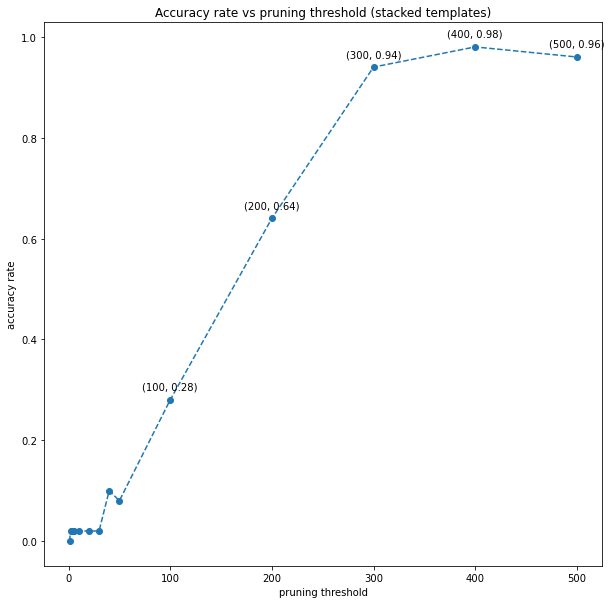

In [220]:
nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
indexes = [1, 2, 3, 4, 5]


# prepare templates and queries
templates = []
for num in nums:
    rec2.read_file("templates/{}_1.wav".format(num))
    template = rec2.get_full_mfcc_list()
    templates.append(template)
queries = {}
for num in nums:
    queries[num] = []
    for index in indexes:
        rec2.read_file("queries/{}_{}.wav".format(num, index))
        query = rec2.get_full_mfcc_list()
        queries[num].append(query)

pruning_Ts = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]
acc_list = []
for pruning_T in pruning_Ts:
    print(f"=====pruning_T={pruning_T}=====")

    startTime = time.time()
    count = 0
    correct_count = 0
    for num_index, num in enumerate(nums):
        for i in indexes:
            count += 1
            query = queries[num][i-1]
            _, _, _, _, results = multi_templates_dtw(query, templates, pruning=True, pruning_T=pruning_T)
            if np.argmin(results) == num_index and np.min(results) != np.inf:
                correct_count += 1
                print(f"query={num}_{i}: correct")
            else:
                print(f"query={num}_{i}: incorrect")

    print("==========")
    acc = correct_count / count
    print("Accuracy rate: ", acc)
    acc_list.append(acc)    
    endTime = time.time()
    print("Running time: ", endTime - startTime)

plt.figure(figsize=(5,5))
plt.plot(pruning_Ts[:], acc_list[:], '--o')
plt.title("Accuracy rate vs pruning threshold (stacked templates)")
plt.xlabel("pruning threshold")
plt.ylabel("accuracy rate")
for x,y in zip(pruning_Ts, acc_list):
    if y > 0.1:
        label = f"({x}, {y})"
        plt.annotate(label,
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')


#### Multiple templates DTW plots

=====template_cnt=1=====
len(templates):  10
query=zero_1: correct
query=zero_2: correct
query=zero_3: correct
query=zero_4: correct
query=zero_5: correct
query=one_1: incorrect
query=one_2: correct
query=one_3: incorrect
query=one_4: incorrect
query=one_5: incorrect
query=two_1: correct
query=two_2: correct
query=two_3: correct
query=two_4: correct
query=two_5: correct
query=three_1: correct
query=three_2: correct
query=three_3: correct
query=three_4: correct
query=three_5: correct
query=four_1: correct
query=four_2: correct
query=four_3: correct
query=four_4: correct
query=four_5: correct
query=five_1: correct
query=five_2: correct
query=five_3: correct
query=five_4: correct
query=five_5: correct
query=six_1: correct
query=six_2: correct
query=six_3: correct
query=six_4: correct
query=six_5: correct
query=seven_1: correct
query=seven_2: correct
query=seven_3: correct
query=seven_4: correct
query=seven_5: correct
query=eight_1: correct
query=eight_2: correct
query=eight_3: correct
que

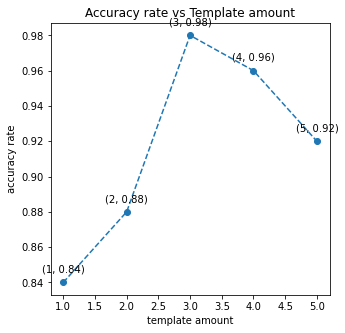

In [55]:
pruning_Ts = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400]

import time
nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
indexes = [1, 2, 3, 4, 5]

# Preprare queries
queries = {}
for num in nums:
    queries[num] = []
    for index in indexes:
        rec2.read_file("queries/{}_{}.wav".format(num, index))
        query = rec2.get_full_mfcc_list()
        queries[num].append(query)
acc_list = []
for template_cnt in range(1, 6):
    print(f"=====template_cnt={template_cnt}=====")
    templates = []
    for num in nums:
        for index in range(1, template_cnt+1):
            rec2.read_file("templates/{}_{}.wav".format(num, index))
            template = rec2.get_full_mfcc_list()
            templates.append(template)
    print("len(templates): ", len(templates))
    

    startTime = time.time()
    count = 0
    correct_count = 0
    for num_index, num in enumerate(nums):
        for i in indexes:
            count += 1
            query = queries[num][i-1]
            _, _, _, _, results = multi_templates_dtw(query, templates, pruning=False)
            if np.argmin(results) // template_cnt == num_index and np.min(results) != np.inf:
                correct_count += 1
                print(f"query={num}_{i}: correct")
            else:
                print(f"query={num}_{i}: incorrect")

    print("==========")
    acc = correct_count / count
    print("Accuracy rate: ", acc)
    acc_list.append(acc)    
    endTime = time.time()
    print("Running time: ", endTime - startTime)


plt.figure(figsize=(5,5))
plt.plot([1,2,3,4,5], acc_list[:], '--o')
plt.title("Accuracy rate vs Template amount")
plt.xlabel("template amount")
plt.ylabel("accuracy rate")
for x,y in zip(pruning_Ts, acc_list):
    if y > 0.1:
        label = f"({x}, {y})"
        plt.annotate(label,
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

#### Multiple templates DTW plot with pruning

=====template_cnt=1=====
len(templates):  10
Running time:  0.17431092262268066
query=zero_1: correct
Running time:  0.19995880126953125
query=zero_2: correct
Running time:  0.18609380722045898
query=zero_3: correct
Running time:  0.20279812812805176
query=zero_4: correct
Running time:  0.17981481552124023
query=zero_5: correct
Running time:  0.24738812446594238
query=one_1: correct
Running time:  0.17369914054870605
query=one_2: correct
Running time:  0.26782822608947754
query=one_3: correct
Running time:  0.1962449550628662
query=one_4: correct
Running time:  0.2271742820739746
query=one_5: correct
Running time:  0.1744987964630127
query=two_1: correct
Running time:  0.18657493591308594
query=two_2: correct
Running time:  0.2258920669555664
query=two_3: correct
Running time:  0.2176346778869629
query=two_4: correct
Running time:  0.19022893905639648
query=two_5: correct
Running time:  0.20700788497924805
query=three_1: correct
Running time:  0.210036039352417
query=three_2: correct
R

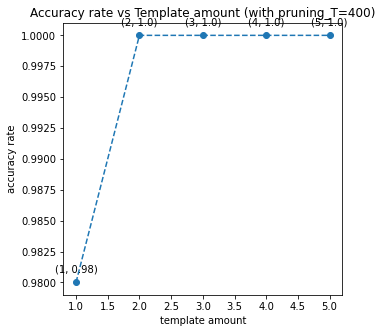

In [56]:
nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
indexes = [1, 2, 3, 4, 5]

# Preprare queries
# queries = {}
# for num in nums:
#     queries[num] = []
#     for index in indexes:
#         rec2.read_file("queries/{}_{}.wav".format(num, index))
#         query = rec2.get_full_mfcc_list()
#         queries[num].append(query)
acc_list = []
for template_cnt in range(1, 6):
    print(f"=====template_cnt={template_cnt}=====")
    templates = []
    for num in nums:
        for index in range(1, template_cnt+1):
            rec2.read_file("templates/{}_{}.wav".format(num, index))
            template = rec2.get_full_mfcc_list()
            templates.append(template)
    print("len(templates): ", len(templates))
    
    # startTime = time.time()
    count = 0
    correct_count = 0
    for num_index, num in enumerate(nums):
        for i in indexes:
            count += 1
            query = queries[num][i-1]
            starTime = time.time()
            _, _, _, _, results = multi_templates_dtw(query, templates, pruning=True, pruning_T=400)
            endTime = time.time()
            print("Running time: ", endTime - starTime)
            if np.argmin(results) // template_cnt == num_index and np.min(results) != np.inf:
                correct_count += 1
                print(f"query={num}_{i}: correct")
            else:
                print(f"query={num}_{i}: incorrect")

    print("==========")
    acc = correct_count / count
    print("Accuracy rate: ", acc)
    acc_list.append(acc)    
    endTime = time.time()
    print("Running time: ", endTime - startTime)
    

plt.figure(figsize=(5,5))
plt.plot([1,2,3,4,5], acc_list[:], '--o')
plt.title("Accuracy rate vs Template amount (with pruning_T=400)")
plt.xlabel("template amount")
plt.ylabel("accuracy rate")
for x,y in zip(pruning_Ts, acc_list):
    if y > 0.1:
        label = f"({x}, {y})"
        plt.annotate(label,
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

## 2. HMM-based for Single Gaussian and Gaussian Mixture

Here we show the code for HMM-based for Multiple Gaussian, it works for single gaussian, too.

In [12]:
num = "one"
indexes = [1, 2, 3, 4, 5]
templates = []
for index in indexes:
    rec2.read_file(f"templates/{num}_{index}.wav")
    template = rec2.get_full_mfcc_list()
    templates.append(template)

In [13]:
import numpy as np
class HMM:
    """ HMM class, now it enables the Gaussian Mixture Model
    
    """
    def __init__(
        self, 
        templates,
        n_states=5,
        n_gaussian=1,
        n_segKMeans_iters=15,
        means_init=None,
        vars_init=None,
        trans_mat_init = None,
        segments_init = None,
        weights=np.array([[1], [1], [1], [1], [1]]),
        clusters=None
        ):
        self.STATES_NUM = n_states
        self.GAUSSIAN_NUM = n_gaussian
        self.MAX_ITERS = n_segKMeans_iters
        self.TEMPLATES = templates
        self.TEMPLATES_NUM = len(templates)
        self.MFCC_N = templates[0].shape[1]
        self.means_init = means_init
        self.vars_init = vars_init
        self.trans_mat_init = trans_mat_init
        self.segments_init = segments_init
        self.HMM_states = None, # a matrix to store the means and vars
        self.trans_mat = None
        self.segments = None
        self.weights = weights
        self.clusters = clusters

        if (means_init is not None) and (vars_init is not None):
            self.init_params(with_init=True)
        else:
            self.init_params()

    def init_params(self, with_init=False):
        if with_init:
            # print("""[INFO] Initializing with given parameters""")
            means = self.means_init
            vars = self.vars_init
            assert (means.shape[0] == vars.shape[0])
            self.HMM_states = np.zeros((2 * means.shape[0], self.MFCC_N, self.GAUSSIAN_NUM)) # shape=(2 * means.shape[0], mfcc_num, gaussian_num)
            self.trans_mat = self.trans_mat_init
            self.segments = self.segments_init
            # Stack the means and vars to struct the HMM_states matrix
            for i in range(means.shape[0]):
                self.HMM_states[2 * i, :, :] = means[i, :, :]
                self.HMM_states[2 * i + 1, :, :] = vars[i, :, :]

        else:
            # print("""[INFO] Initializing with default parameters""")
            self.HMM_states = np.zeros((2 * self.STATES_NUM, self.MFCC_N, self.GAUSSIAN_NUM))
            self.trans_mat = np.array([ [1e-10, 1e-10, 1],
                                        [1e-10, 0.5, 0.5],
                                        [0.6, 0.2, 0.2],
                                        [0.6, 0.2, 0.2],
                                        [0.6, 0.2, 0.2],
                                        [0.5, 0.5, 0],
                                        [1, 0, 0]])
            self.trans_mat = - np.log(self.trans_mat)
            segments = []
            for i in range(self.TEMPLATES_NUM):
                frame_length = templates[i].shape[0]
                splits = np.array_split(np.arange(frame_length), self.STATES_NUM)
                segments.append([len(x) for x in splits])
            segments = np.array(segments)
            self.segments = segments
            self.update_state_data()
    
    def update_state_data(self):
        """ update the state_data. state_data stores all the vectors belonging to each state.
        
        e.g. state_data=[
            [array with shape (114, 39)],    # state 0
            [array with shape (46, 39)],     # state 1
            [array with shape (152, 39)]]     # state 2

        """
        states_data = []
        current_frames = [0] * self.TEMPLATES_NUM            # store the cursor
        for i in range(self.STATES_NUM):
            tmp = np.zeros((1, self.MFCC_N))
            for j in range(self.TEMPLATES_NUM):
                frame_length = self.segments[j, i]
                for k in range(frame_length):
                    frame = templates[j][current_frames[j] + k]
                    tmp = np.vstack((tmp, frame))
                current_frames[j] += frame_length
            tmp = tmp[1:]
            states_data.append(tmp)
            # print(tmp.shape)
        self.states_data = states_data
        # print(states_data)
        # return states_data[state_i]
        
    def get_state_i_data(self, i):
        """ get the all vectors belongs to the state_i. The shape is (x, MFCC_N)
        
        Args:
            i: the index of the state
        Return:
            state_i_data: the data of the corresponding state
        """
        return self.states_data[i]

    def _dtw(self, query):
        """ inner function of dtw, with weights

        Args:
            query: query sequence
            weights: weights of the each gaussian
        Return:
            
        """
        trans_mat = self.trans_mat
        weights = self.weights

        assert(np.sum(weights[i, :]) == 1 for i in range(weights.shape[0]))

        from scipy.spatial.distance import cdist
        HMM_states_means = self.HMM_states[::2, :, :]
        HMM_states_vars = self.HMM_states[1::2, :, :]

        # means:
        # state0_means | (0, 1, ..., 39) | mean1, mean2, ...
        # state1_means | (0, 1, ..., 39) | mean1, mean2, ...

        # vars:
        # state0_vars  | (0, 1, ..., 39) | vars1, vars2, ...
        # state1_vars  | (0, 1, ..., 39) | vars1, vars2, ...

        dist_mat = np.zeros((self.STATES_NUM, query.shape[0]))
        for i in range(self.STATES_NUM):
            distances = []
            for j in range(self.GAUSSIAN_NUM):
                means = HMM_states_means[i, :, j]
                vars = HMM_states_vars[i, :, j]
                # print("means: ", means)
                # print("vars: ", vars)
                D = len(means)
                cov_I = np.linalg.inv(np.diag(vars))
                mahala_dist = cdist(np.matrix(means), query, 'mahalanobis', VI=cov_I)
                distance = 0.5 * mahala_dist + D * 0.5 * np.log(2 * np.pi) + 0.5 * np.prod(vars) - np.log(weights[i, j])  ### here to modify
                distances.append(distance)
            dist_mat[i] = np.sum([x * y for x, y in zip(distances, weights[i])], axis=0)
            
        # print(dist_mat)
        inf_row = np.zeros(query.shape[0]) + np.inf
        # print(dist_mat.shape)
        dist_mat = np.vstack((inf_row, inf_row, dist_mat))
        inf_col = np.zeros((dist_mat.shape[0], 1)) + np.inf
        dist_mat = np.hstack((inf_col, dist_mat))
        # print(dist_mat)

        M, N = dist_mat.shape
        cost_mat = np.zeros((M, N)) + np.inf
        cost_mat[0, 0] = 0
        traceback_mat = np.zeros((M, N))
        # trans_mat = self.trans_mat
        
        for j in range(1, N):
            for i in range(2, M):
                penalty = [
                    np.inf,                 # stop (0)
                    cost_mat[i, j-1] + trans_mat[i, 0],       # horizon (1) 
                    cost_mat[i-1, j-1] + trans_mat[i-1, 1],     # diag (2)  
                    cost_mat[i-2, j-1] + trans_mat[i-2, 2]      # super-diag (3) 
                ]
                i_penalty = np.argmin(penalty)
                traceback_mat[i, j] = i_penalty
                cost_mat[i, j] = penalty[i_penalty] + dist_mat[i, j]
        
        i = M - 1
        j = N - 1
        last_index = (i, j)
        path = [last_index]
        while i > 0 or j > 0:
            tb_type = traceback_mat[i, j]
            if tb_type == 0:
                break
            elif tb_type == 1:
                # horizon
                j = j - 1
            elif tb_type == 2:
                # diag
                i = i - 1
                j = j - 1
            elif tb_type == 3:
                # super-diag
                i = i - 2
                j = j - 1
            path.append((i, j))
        path = path[::-1][1:]

        new_path = np.array(path)
        seg = np.bincount(new_path[:, 0])[2:]

        best_cost = cost_mat[-1, -1]

        return path, seg, best_cost, cost_mat, dist_mat


    def _calc_trans_mat(self, segments):
        """ calculate the transition matrix based on segments
        
        Args: 
            segments: the segments data looks like this: \n
            segments = [[24 24 24 23 23]\n
                        [28 28 28 27 27]\n
                        [28 28 28 27 27]\n
                        [20 20 20 19 19]\n
                        [24 24 24 23 23]]
        Return:
            trans_mat
        """
        trans_mat = np.array([
            [1e-10, 1e-10, 1],
            [1e-10, 0.5, 0.5]
        ])
        for i in range(self.STATES_NUM - 1):
            denominator = np.sum(segments[:, i])
            next_nonzeros = np.count_nonzero(segments[:, i+1])
            next_zeros = len(segments[:, i+1]) - next_nonzeros
            P_next = next_nonzeros / denominator
            P_next_next = next_zeros / denominator
            P_self = (denominator - next_zeros - next_nonzeros) / denominator
            trans_prob = [P_self, P_next, P_next_next]
            trans_mat = np.vstack((trans_mat, trans_prob))
        last_trans_prob = [1, 0, 0]
        trans_mat = np.vstack((trans_mat, last_trans_prob))
        trans_mat += 1e-5
        # print(segments)
        # print(trans_mat)
        trans_mat = - np.log(trans_mat)
        # print(trans_mat.shape)
        return trans_mat

    def train(self):
        """ Train the HMM model using segmental K-means
        
        """
        for iter in range(self.MAX_ITERS):
            # print("hmm_states shape: ", self.HMM_states.shape)
            for state_i in range(self.STATES_NUM):
                # data = self.get_state_i_data(state_i)  ### 把这个改成data = cluster[state_i][j]应该就好了
                for j in range(self.GAUSSIAN_NUM):
                    if self.GAUSSIAN_NUM > 1:
                        data = self.clusters[state_i][j]
                    else:
                        data = self.get_state_i_data(state_i)
                    # means
                    self.HMM_states[2 * state_i, :, j] = np.mean(data, axis=0)
                    # vars
                    self.HMM_states[2 * state_i + 1, :,  j] = np.diag(np.corrcoef(data, rowvar=0))

            # loop all templates, do dtw
            best_costs = []                                 # store best_costs
            for j in range(self.TEMPLATES_NUM):
                template = templates[j]
                _, seg, best_cost, _, _ = self._dtw(template)
                
                # update template segments
                self.segments[j] = seg
                # store best_cost
                best_costs.append(best_cost)
            # print(self.segments)
            self.update_state_data()
            avg_best_cost = np.mean(best_costs)
            self.trans_mat = self._calc_trans_mat(self.segments)

            print(f"iter={iter}, avg_score={avg_best_cost}")

    def get_trans_mat(self):
        return self.trans_mat
    
    def get_HMM_states(self):
        return self.HMM_states

    def save(self, filename):
        np.savez(filename, HMM_states=self.HMM_states, trans_mat=self.trans_mat)


In [22]:
weights = np.array([[1], [1], [1], [1], [1]])
print(weights.shape)
HMM_1_gaussian = HMM(templates, n_states=5, n_gaussian=1, weights=weights)
HMM_1_gaussian.train()
# HMM_1_gaussian.save("models/one_hmm_1_gauss.npz")

(5, 1)
iter=0, avg_score=7674.810843133457
iter=1, avg_score=7551.040093202825
iter=2, avg_score=7531.654825293639
iter=3, avg_score=7518.092034366744
iter=4, avg_score=7505.895836042975
iter=5, avg_score=7498.736835332548
iter=6, avg_score=7495.302062389778
iter=7, avg_score=7495.020857041612
iter=8, avg_score=7494.758988564677
iter=9, avg_score=7494.653674831281
iter=10, avg_score=7494.653674831281
iter=11, avg_score=7494.653674831281


/var/folders/pd/g_gtf24513q906yxb_0d31dm0000gn/T/ipykernel_50587/210569613.py:64: RuntimeWarning: divide by zero encountered in log
  self.trans_mat = - np.log(self.trans_mat)


iter=12, avg_score=7494.653674831281
iter=13, avg_score=7494.653674831281
iter=14, avg_score=7494.653674831281


In [18]:
def cluster_centroids(data, clusters, k):
    result = np.empty(shape=(k,) + data.shape[1:])
    for i in range(k):
        np.mean(data[clusters == i, :], axis=0, out=result[i])
    return result

def calc_variance(data):
    return np.corrcoef(data).diagonal()
    
def kmeans(data, k, centroids, dist_fun=lambda *args: np.linalg.norm(args[0] - args[1]), max_iteration=1000):
    clusters = np.random.randint(0, k, data.shape[0])
    # find the covariance matrix of the new clusters
    cov = []
    for c in range(k):
        segments = data[clusters == c]
        cov.append(calc_variance(segments.T))
    cov = np.array(cov)
    # calculate distance from centroids
    for _ in range(max(max_iteration, 1)):
        dists = np.zeros((data.shape[0], k))
        for i in range(data.shape[0]):
            for c in range(k):
                dists[i, c] = dist_fun(centroids[c, :], data[i, :], cov[0])
        dists = np.array(dists)
        # Index of the closest centroid to each data point.
        clusters = np.argmin(dists, axis=1)
        new_centroids = cluster_centroids(data, clusters, k)

        # check convergence
        if np.array_equal(new_centroids, centroids):
            break
        centroids = new_centroids
    return clusters, centroids, cov

def mahalanobis(v1, v2, variance):
    D = len(variance)
    m = (v1 - v2)
    return 0.5 * np.log((2 * np.pi) ** D * np.prod(variance)) + 0.5 * np.sum(m / variance * m)

def split(data, n_gaussian, centroids, n_splits):
    weights = np.full(n_gaussian, 1 / data.shape[0])
    for i in range(n_splits):
        lcentroids = centroids * 0.9
        hcentroids = centroids * 1.1
        centroids = np.vstack((lcentroids, hcentroids))
        print("centroids.shape: ", centroids.shape)
        clusters, centroids, variance = kmeans(data, 2 ** (i + 1), centroids, dist_fun=mahalanobis)
        centroids = centroids
        variance = variance
        # calculate and update weights of distributions
        cs, c_counts = np.unique(clusters, return_counts=True)
        for c in cs:
            weights[c] = c_counts[c] / data.shape[0]
            
    return clusters, weights, centroids, variance

In [20]:
def split_and_kmeans(HMM_Model, n_splits):
    current_n_gaussian = HMM_Model.GAUSSIAN_NUM
    STATES_NUM = HMM_Model.STATES_NUM
    MFCC_N = HMM_Model.MFCC_N

    weights = []
    clusters = []
    means = np.zeros((STATES_NUM, MFCC_N, current_n_gaussian * 2 ** n_splits))
    vars = np.zeros((STATES_NUM, MFCC_N, current_n_gaussian * 2 ** n_splits))

    for i in range(STATES_NUM):
        data = HMM_Model.get_state_i_data(i)
        centroids = np.array(HMM_Model.HMM_states[i*2]).T
        print("centroids.shape: ", centroids.shape)
        n_gaussian = current_n_gaussian * (2 ** n_splits)
        cluster, weight, mean, var = split(data, n_gaussian, centroids, n_splits)
        mean = mean.reshape((1, MFCC_N, current_n_gaussian * 2 ** n_splits))
        var = var.reshape((1, MFCC_N, current_n_gaussian * 2 ** n_splits))
        for j in range(current_n_gaussian * 2 ** n_splits):
            means[i, :, j] = mean[0, :, j]
            vars[i, :, j] = var[0, :, j]

        tmp = []

        for i in range(n_gaussian):
            cluster_data_i = data[cluster==i]
            tmp.append(cluster_data_i)
        clusters.append(tmp)
        weights.append(weight)

    weights = np.array(weights)
    return clusters, weights, means, vars

In [21]:
"""
Main function
"""
weights = np.array([[1], [1], [1], [1], [1]])

HMM_1_gaussian = HMM(templates, n_states=5, n_gaussian=1)
HMM_1_gaussian.train()
trans_mat = HMM_1_gaussian.get_trans_mat()
segments = HMM_1_gaussian.segments

# split twice to generate 4 gaussian mixture model
clusters, weights, means, vars = split_and_kmeans(HMM_1_gaussian, n_splits=2)
HMM_4_gaussian = HMM(templates, n_states=5, n_gaussian=4, means_init=means, vars_init=vars, trans_mat_init=trans_mat, weights=weights, clusters=clusters, segments_init=segments)
HMM_4_gaussian.train()
HMM_4_gaussian.save("models/one_HMM_4_gaussian.npz")


/var/folders/pd/g_gtf24513q906yxb_0d31dm0000gn/T/ipykernel_50587/210569613.py:64: RuntimeWarning: divide by zero encountered in log
  self.trans_mat = - np.log(self.trans_mat)


iter=0, avg_score=7674.810843133457
iter=1, avg_score=7551.040093202825
iter=2, avg_score=7531.654825293639
iter=3, avg_score=7518.092034366744
iter=4, avg_score=7505.895836042975
iter=5, avg_score=7498.736835332548
iter=6, avg_score=7495.302062389778
iter=7, avg_score=7495.020857041612
iter=8, avg_score=7494.758988564677
iter=9, avg_score=7494.653674831281
iter=10, avg_score=7494.653674831281
iter=11, avg_score=7494.653674831281
iter=12, avg_score=7494.653674831281
iter=13, avg_score=7494.653674831281
iter=14, avg_score=7494.653674831281
centroids.shape:  (1, 39)
centroids.shape:  (2, 39)
centroids.shape:  (4, 39)
centroids.shape:  (1, 39)
centroids.shape:  (2, 39)
centroids.shape:  (4, 39)
centroids.shape:  (1, 39)
centroids.shape:  (2, 39)
centroids.shape:  (4, 39)
centroids.shape:  (1, 39)
centroids.shape:  (2, 39)
centroids.shape:  (4, 39)
centroids.shape:  (1, 39)
centroids.shape:  (2, 39)
centroids.shape:  (4, 39)
checkpoint1
[[0.36125654 0.27748691 0.29842932 0.06282723]
 [0.28